In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sonukiran896","key":"c18751916df1fefbde1e1026fabbe8ed"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

!unzip -qq dogs-vs-cats.zip
!unzip -qq test1.zip
!unzip -qq train.zip

 99% 802M/812M [00:06<00:00, 155MB/s]
100% 812M/812M [00:06<00:00, 140MB/s]


**Training sample of 1000, a validation sample of 500, and a test sample of 500**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

Training Set

In [ ]:
make_subset("train", start_index=0, end_index=1000)

Validation Set

In [ ]:
make_subset("validation", start_index=1000, end_index=1500)

Test Set

In [ ]:
make_subset("test", start_index=1500, end_index=2000)

Data Processing

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
      break
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Building the Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 180s 3s/step - loss: 0.7033 - accuracy: 0.5075 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 176s 3s/step - loss: 0.6953 - accuracy: 0.5395 - val_loss: 0.6822 - val_accuracy: 0.6120
Epoch 3/30
63/63 [==============================] - 199s 3s/step - loss: 0.6884 - accuracy: 0.5565 - val_loss: 0.6845 - val_accuracy: 0.5050
Epoch 4/30
26/63 [===========>..................] - ETA: 1:30 - loss: 0.6918 - accuracy: 0.5865

Accuracy Plots

<Figure size 432x288 with 0 Axes>

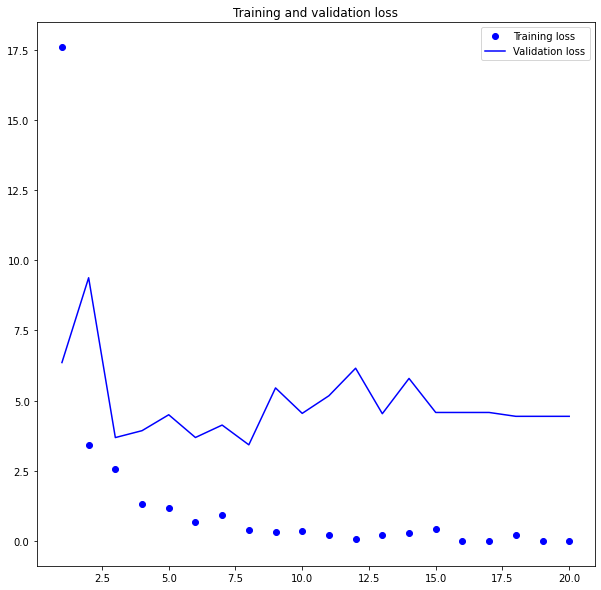

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Model Evaluation

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.5775 - accuracy: 0.7070
Test accuracy: 0.707


**Question** **2**

Data Augmentation

In [ ]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Image Augmentation and Dropout

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 17s 212ms/step - loss: 0.6967 - accuracy: 0.4975 - val_loss: 0.8043 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 13s 207ms/step - loss: 0.6940 - accuracy: 0.5225 - val_loss: 0.6802 - val_accuracy: 0.5950
Epoch 3/50
63/63 [==============================] - 13s 199ms/step - loss: 0.6805 - accuracy: 0.5755 - val_loss: 0.6777 - val_accuracy: 0.5460
Epoch 4/50
63/63 [==============================] - 13s 202ms/step - loss: 0.6681 - accuracy: 0.5950 - val_loss: 0.6470 - val_accuracy: 0.6230
Epoch 5/50
63/63 [==============================] - 13s 201ms/step - loss: 0.6493 - accuracy: 0.6345 - val_loss: 0.6420 - val_accuracy: 0.6300
Epoch 6/50
63/63 [==============================] - 13s 201ms/step - loss: 0.6450 - accuracy: 0.6320 - val_loss: 0.6377 - val_accuracy: 0.6210
Epoch 7/50
63/63 [==============================] - 13s 200ms/step - loss: 0.6291 - accuracy: 0.6485 - val_loss: 0.6517 - val_accuracy: 0.6260
Epoch 8/50

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.5169 - accuracy: 0.7650
Test accuracy: 0.765


**Question**3 **bold text**

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#As increasing the sample size is always good than decreasing, here we're increasing the training the sample size to 2000
make_subset("train", start_index=0, end_index=2000)
#validation and test sample size 500 each
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 18s 201ms/step - loss: 0.6877 - accuracy: 0.5235 - val_loss: 0.6739 - val_accuracy: 0.6010
Epoch 2/50
63/63 [==============================] - 13s 197ms/step - loss: 0.6676 - accuracy: 0.6025 - val_loss: 0.6450 - val_accuracy: 0.6070
Epoch 3/50
63/63 [==============================] - 13s 197ms/step - loss: 0.6375 - accuracy: 0.6495 - val_loss: 0.5949 - val_accuracy: 0.6750
Epoch 4/50
63/63 [==============================] - 13s 197ms/step - loss: 0.5995 - accuracy: 0.6800 - val_loss: 0.6629 - val_accuracy: 0.6430
Epoch 5/50
63/63 [==============================] - 12s 194ms/step - loss: 0.6056 - accuracy: 0.6735 - val_loss: 0.5980 - val_accuracy: 0.6690
Epoch 6/50
63/63 [==============================] - 13s 197ms/step - loss: 0.5823 - accuracy: 0.6935 - val_loss: 0.5570 - val_accuracy: 0.7110
Epoch 7/50
63/63 [==============================] - 13s 198ms/step - loss: 0.5491 - accuracy: 0.7305 - val_loss: 0.5716 - val_accuracy: 0.6910
Epoch 8/50

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

NameError: ignored

**Question 4**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 25ms/step


In [ ]:
train_features.shape

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 22s 288ms/step - loss: 19.0103 - accuracy: 0.9030 - val_loss: 4.9781 - val_accuracy: 0.9650
Epoch 2/50
63/63 [==============================] - 18s 279ms/step - loss: 7.0579 - accuracy: 0.9480 - val_loss: 5.2746 - val_accuracy: 0.9650
Epoch 3/50
63/63 [==============================] - 18s 281ms/step - loss: 4.2097 - accuracy: 0.9600 - val_loss: 7.1299 - val_accuracy: 0.9600
Epoch 4/50
63/63 [==============================] - 18s 281ms/step - loss: 4.8428 - accuracy: 0.9610 - val_loss: 5.3644 - val_accuracy: 0.9730
Epoch 5/50
63/63 [==============================] - 18s 279ms/step - loss: 3.2294 - accuracy: 0.9695 - val_loss: 5.0918 - val_accuracy: 0.9760
Epoch 6/50
63/63 [==============================] - 18s 279ms/step - loss: 2.6453 - accuracy: 0.9755 - val_loss: 20.5819 - val_accuracy: 0.9210
Epoch 7/50
63/63 [==============================] - 18s 282ms/step - loss: 2.6515 - accuracy: 0.9775 - val_loss: 5.2338 - val_accuracy: 0.9690
Epoch 8/

Model Evaluation

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 97ms/step - loss: 6.0132 - accuracy: 0.9750
Test accuracy: 0.975


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine Tuning the Model

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


63/63 [==============================] - 25s 325ms/step - loss: 0.3020 - accuracy: 0.9945 - val_loss: 3.6697 - val_accuracy: 0.9780
Epoch 2/30
63/63 [==============================] - 21s 331ms/step - loss: 0.5257 - accuracy: 0.9940 - val_loss: 3.6595 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 19s 299ms/step - loss: 0.5373 - accuracy: 0.9925 - val_loss: 3.5318 - val_accuracy: 0.9750
Epoch 4/30
63/63 [==============================] - 20s 316ms/step - loss: 0.4474 - accuracy: 0.9955 - val_loss: 2.7913 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 21s 328ms/step - loss: 0.3355 - accuracy: 0.9930 - val_loss: 3.9728 - val_accuracy: 0.9740
Epoch 6/30
63/63 [==============================] - 19s 295ms/step - loss: 0.5172 - accuracy: 0.9925 - val_loss: 5.7597 - val_accuracy: 0.9680
Epoch 7/30
63/63 [==============================] - 20s 308ms/step - loss: 0.3980 - accuracy: 0.9945 - val_loss: 4.1146 - val_accuracy: 0.9760
Epoch 8/30

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 89ms/step - loss: 3.6287 - accuracy: 0.9760
Test accuracy: 0.976
